In [1]:
#@title <font color='yellow'>Install package
%%capture cap --no-stderr
import sys
!pip uninstall tensorflow -y
print('pip uninstall tensorflow -y ...',file=sys.stderr)
!pip uninstall tensorflow-gpu -y
print('pip uninstall tensorflow-gpu -y ...',file=sys.stderr)
!pip install tensorflow==1.15
print('pip install tensorflow==1.15 ...',file=sys.stderr)
!pip install tensorflow-gpu==1.15
print('pip install tensorflow-gpu==1.15 ...',file=sys.stderr)
!pip install -q lucid
print('pip install -q lucid ...',file=sys.stderr)

pip uninstall tensorflow -y ...
pip uninstall tensorflow-gpu -y ...
pip install tensorflow==1.15 ...
pip install tensorflow-gpu==1.15 ...
pip install -q lucid ...


In [2]:
#@title <font color='yellow'>3D model data
VertexList = [[-0.400000,0.400000,0.0],
[-0.282946,0.388471,0.0],
[-0.170390,0.354328,0.0],
[-0.066658,0.298882,0.0],
[0.024264,0.224264,0.0],
[0.098882,0.133342,0.0],
[0.154328,0.029610,0.0],
[0.188471,-0.082946,0.0],
[0.200000,-0.200000,0.0],
[0.188471,-0.317054,0.0],
[0.154328,-0.429610,0.0],
[0.098882,-0.533342,0.0],
[0.024264,-0.624264,0.0],
[-0.066658,-0.698882,0.0],
[-0.170390,-0.754328,0.0],
[-0.282946,-0.788471,0.0],
[-0.400000,-0.800000,0.0],
[-0.517054,-0.788471,0.0],
[-0.629610,-0.754328,0.0],
[-0.733342,-0.698882,0.0],
[-0.824264,-0.624264,0.0],
[-0.898882,-0.533342,0.0],
[-0.954328,-0.429610,0.0],
[-0.988471,-0.317054,0.0],
[-1.000000,-0.200000,0.0],
[-0.988471,-0.082946,0.0],
[-0.954328,0.029610,0.0],
[-0.898882,0.133342,0.0],
[-0.824264,0.224264,0.0],
[-0.733342,0.298882,0.0],
[-0.629610,0.354328,0.0],
[-0.517054,0.388471,0.0],
[-0.500000,0.123431,0.0],
[-0.443431,0.500000,0.0],
[-0.556569,0.500000,0.0],
[-0.500000,0.556569,0.0],
[0.300000,0.050503,0.0],
[0.849497,0.100000,0.0],
[0.250502,0.100000,0.0],
[0.300000,0.149498,0.0]]

# 26 triangles
BodyIndex=[[26,18,10],
[2,1,0],
[0,31,2],
[31,30,2],
[30,29,28],
[28,27,26],
[26,25,22],
[25,24,22],
[24,23,22],
[22,21,20],
[20,19,18],
[18,17,14],
[17,16,14],
[16,15,14],
[14,13,12],
[12,11,10],
[10,9,6],
[9,8,6],
[8,7,6],
[6,5,4],
[4,3,2],
[30,28,26],
[22,20,26],
[20,18,26],
[14,12,18],
[12,10,18],
[6,4,10],
[4,2,10],
[2,30,26],
[2,26,10]]

# 2 triangles
hourHandIndex=[[33,34,32],[33,35,34]]

# 2 triangles
minuteHandIndex=[[36,39,38],[36,37,39]]

### begin translation matrix
pos_body = [-0.4, -0.2,  0]
pos_hour = [-0.5,  0.5,  0]
pos_min  = [ 0.3,  0.1,  0]
pos_ori  = [ 0.0,  0,  0]

In [3]:
# import package
import lucid.misc.io.showing as show
import ctypes.util # for import lucid.misc bug
from lucid.misc.gl.glcontext import create_opengl_context
from OpenGL.GL import *
from OpenGL.GLU import *
import numpy as np
import time
from IPython.display import clear_output

In [4]:
class mat(np.ndarray):
    def __mul__(self,m2): 			# overload a*b
        if type(m2)==mat:  			# a[3x3] * b[3x3]
            return np.dot(self,m2)
        else:						# a[3x3] * b[3x1]
            return list(np.dot(np.array(self),np.array(m2[:2]+[1]).reshape([3,1])).flatten())
    def new(matrix):
        if type(matrix)==list:
            matrix = np.array(matrix)
        re = mat(matrix.shape)
        if len(re.shape)==1:
            re[:] = matrix[:]
        else:
            re[:,:] = matrix[:,:]        
        return re
    def trans(pos): 				# offset = -position 
        re = mat.new([
        [1,0,-pos[0]],
        [0,1,-pos[1]],
        [0,0,1]])
        return re 
    def rotate(radius):
        re = mat.new([
        [np.cos(radius),-np.sin(radius),0],
        [np.sin(radius), np.cos(radius),0],
        [      0,        0,1]])
        return re        


def draw(color,object,pos,radius):
    glColor3f(color[0],color[1],color[2])
    glBegin(GL_TRIANGLES)
    for fID in object:
    	# p' = S.T.p
        glVertex3fv(mat.rotate(radius)*mat.trans(pos)*VertexList[fID[0]])
        glVertex3fv(mat.rotate(radius)*mat.trans(pos)*VertexList[fID[1]])
        glVertex3fv(mat.rotate(radius)*mat.trans(pos)*VertexList[fID[2]])
    glEnd()

def drawBody():
	draw(color=[1,1,1],object=BodyIndex,pos=pos_body,radius=0)
def drawhourHand():
	draw(color=[1,0,0],object=hourHandIndex,pos=pos_hour,radius=-count)
def drawminuteHand():
	draw(color=[0,1,0],object=minuteHandIndex,pos=pos_min,radius=-count*60)	
 
# display
def glutPostRedisplay():
  img_buf = glReadPixelsub(0, 0, WIDTH, HEIGHT, GL_RGB, GL_UNSIGNED_BYTE)
  img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
  show.image(img/255.0)
  time.sleep(0.1)
  clear_output(wait=True)  

def dispaly_start(w,h):
  global WIDTH, HEIGHT
  WIDTH, HEIGHT = w, h
  create_opengl_context((WIDTH, HEIGHT))     
  # print(glGetString(GL_VERSION))
  # print(glGetString(GL_VENDOR)) 

def display():
  global count
  dispaly_start(600,600)
  time_tmp = time.time()
  for count in np.linspace(0.0, 0.1, num=100):
    glClear(GL_COLOR_BUFFER_BIT)
    drawBody()
    drawhourHand()
    drawminuteHand()
    glutPostRedisplay()
    while (time.time()-time_tmp)<1:
      time.sleep(0.2)
    time_tmp = time.time()


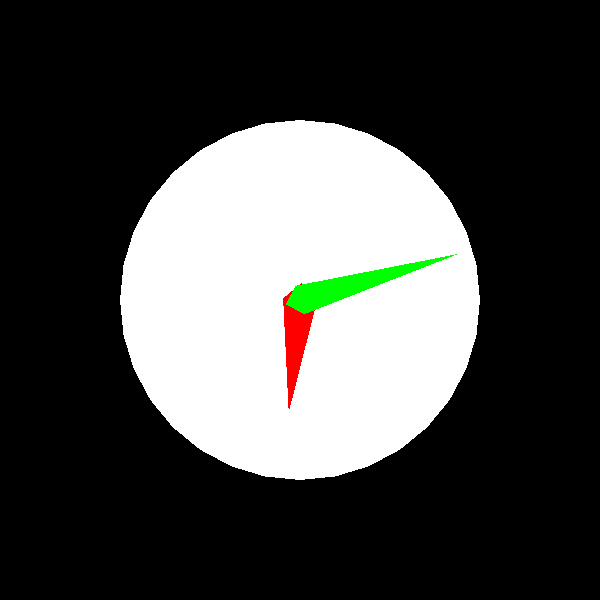

In [5]:
display()